<a href="https://colab.research.google.com/github/deepskies/proj-clusters-sz-sbi/blob/sim_dev/mass_sampling_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# all packages
! pip install colossus

from colossus.cosmology import cosmology
from colossus.lss import mass_function
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn import preprocessing
from scipy import interpolate
from scipy import integrate

import math
!pip install emcee
import emcee
import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 197 kB 8.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 3.1 MB/s 


In [2]:
#extract power function
def extract_power(mass_arr, mfunc):
  """
  Function to extract power of galaxy cluster mass array, and normalize mfunc, prepare for 

  parameters:
  -----------
  mass_arr: 1d numpy array of cluster mass in 10^n M⊙ unit
  mfunc: 1d numpy array of halo numbr density in dN/dlog(M)(Mpc/ℎ)^(−3) unit

  mass_arr_p: 1d numpy array of mass of power = n
  mfunc_n: 1d numpy array of halo number density * 10^5
  """
  mass_arr_p = np.log10(mass_arr)
  mfunc_n = mfunc*(10**5)
  return mass_arr_p, mfunc_n 

In [3]:
#the likelihood function
def lnpo(mass, min, max, test_fun):
  """
  likelihood function used by MCMC

  parameters:
  -----------
  mass: a float or a 1d numpy array of cluster mass in 10^n M⊙ unit
  """
  if (mass < min) or (mass > max):
    return -np.inf
  return math.log(test_fun(mass)) #log likelihood is required by emcee

In [4]:
def interpolate_MCMC(mass_array_p, mfunc_n, mass_range, sample_num):
  """
  interpolate and normalize mfunc_n, use the result as a likelihood function and perform MCMC method to get sample.

  parameters:
  -----------
  mass_arr_p: 1d numpy array of cluster mass power (for example, 10^14 M⊙ represented as 14 in arr)
  mfunc_n: 1d numpy array of halo number density * 10^5
  mass_range: a tuple of cluster masses, lower limit and upper limit for sampling
  sample_num: an integer of number of sample

  sample_chain.flatten(): an 1d numpy array of mass sampling, same unit as mass_arr_p
  """
  min, max = mass_range
  print(min, max)
  #interpolate
  from scipy import interpolate
  interpolate_mfunc = interpolate.interp1d(mass_array_p, mfunc_n)
  test_arr = np.linspace(min, max, 5000)
  f_test = interpolate_mfunc(test_arr)
  #normalize to likelihood function by divided by integration, looking for better method
  from scipy import integrate
  val, err = integrate.quad(interpolate_mfunc, min, max)
  test_fun = interpolate.interp1d(test_arr, (f_test/val))
  #plt.plot(test_arr, f_test/val, marker = 'o')
  #nval, nerr = integrate.quad(test_fun, min, max), 5000 test points will lead to error < 10^-4

  #create random walkers
  import emcee
  import random
  randomlist = []
  for i in range(20):
    n = random.uniform(min, max)
    randomlist.append(n)
  random_arr = np.array(randomlist)

  #run MCMC
  ndim, nwalkers = 1, 20
  p0 = random_arr.reshape((nwalkers, ndim))
  sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpo, args = [min, max, test_fun])
  pos, prob, state = sampler.run_mcmc(p0, 25000) #burn-in sequence
  sampler.reset()
  sampler.run_mcmc(pos, (sample_num // (ndim * nwalkers)))
  mass_chain = sampler.chain[:, :, :].reshape((-1, ndim))
  return test_fun, mass_chain.flatten()


In [5]:
def mass_sampling(mass_range, redshift = 0.0, mdef = '200c', model = 'bocquet16', sample_num = 50000):
  """
  the function to give back a sample of mass distribution based on halo mass function 
     
  Parameters:
  ----------- 
  mass_range: a tuple of cluster masses, lower limit and upper limit for sampling
  redshift: a float, 0.0 by deault
  sample_num: an integer of number of sample, 100000 by default
  mdef: The mass definition in which the halo mass M is given
  model: the halo mass function model used by colossus 

  mass_chain: a numpy array of length = sample_num.
  test_func: the likelihood function
  """
  from colossus.cosmology import cosmology
  from colossus.lss import mass_function
  import numpy as np
  min, max = mass_range
  mass_arr = np.logspace(min, max, num = 200, base = 10)
  cosmology.setCosmology('WMAP9')
  mfunc = mass_function.massFunction(mass_arr, redshift, mdef = mdef, model = model, q_out = 'dndlnM')
  mass_arr_p, mfunc_n = extract_power(mass_arr, mfunc)
  test_func, prim_mass_sample = interpolate_MCMC(mass_arr_p, mfunc_n, mass_range, sample_num)
  #mass_chain = np.power(10, prim_mass_sample)
  return test_func, prim_mass_sample

test

In [16]:
#code to demonstrate the final result
def plot_pdf(xr, title, func=None, args=None, label='ITS method', 
             ylog=True,
             bins = 50, xlims=[], ylims=[], figsize=3):
    """
    by Andrey Kravtsov
    wrapper convenience function for plotting  histogram of a sequence of floats xr
    and comparing it to a theoretical distribution given by func
    
    Parameters:
    -----------
    xr: 1d numpy array of floats, values in the sequence to plot
    func: Python function object handle
    args: list of arguments to the function
    other parameters are used for plotting
    """
    plt.figure(figsize=(figsize,figsize))
    if ylog: plt.yscale('log') # plot y-values on a logarithmic scale
    if ylims: plt.ylim(ylims) # set axis limits 
    if xlims: plt.xlim(xlims)
    # compute histogram values 
    hist, bins, patches = plt.hist(xr, density=True, bins=bins, label=label)
    binc = 0.5*(bins[1:] + bins[:-1]) # compute bin centers
    plt.plot(binc, func(binc), lw=5, c='orangered', label='target pdf')
    plt.title(title, fontsize=3*figsize)
    plt.ylabel(r'$likelihood$') # label axis 
    plt.xlabel(r'$mass$')
    plt.legend(loc='best', frameon=False, fontsize=3*figsize)
    plt.show()

Deleted outdated persistence file, no further action needed.
14.0 16.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


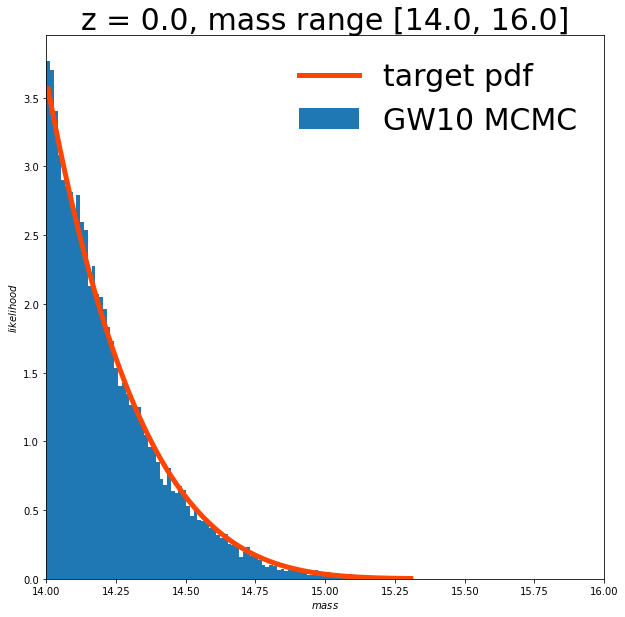

In [17]:
#simplest case
mass_range = [14.0, 16.0]
test_func, mass_chain = mass_sampling(mass_range)
plot_pdf(mass_chain, "z = 0.0, mass range [14.0, 16.0]", func=test_func, xlims=mass_range, ylog=False, bins='auto', label='GW10 MCMC', figsize = 10)

Deleted outdated persistence file, no further action needed.
14.0 16.0


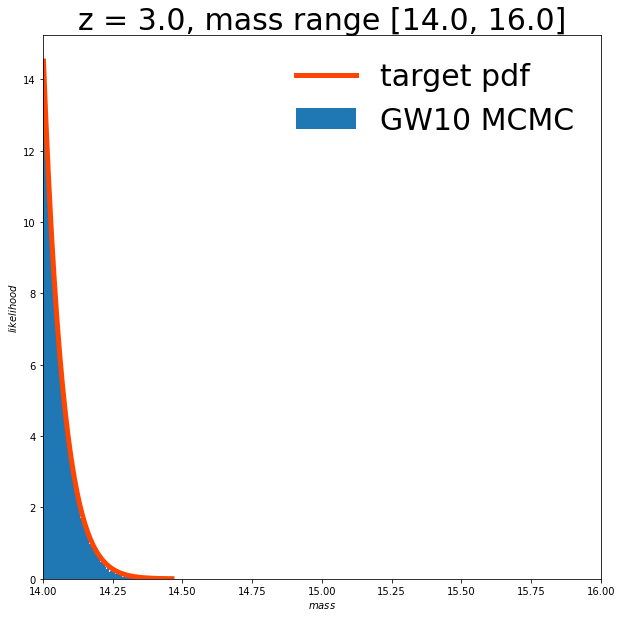

In [18]:
test_func, mass_chain = mass_sampling(mass_range, redshift = 3.0)
plot_pdf(mass_chain, "z = 3.0, mass range [14.0, 16.0]", func=test_func, xlims=mass_range, ylog=False, bins='auto', label='GW10 MCMC', figsize = 10)

Deleted outdated persistence file, no further action needed.
14.0 16.0


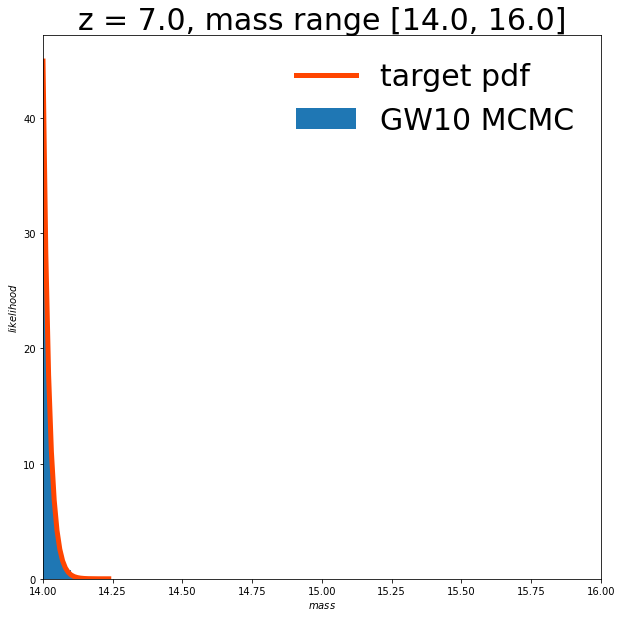

In [19]:
test_func, mass_chain = mass_sampling(mass_range, redshift = 7.0)
plot_pdf(mass_chain, "z = 7.0, mass range [14.0, 16.0]", func=test_func, xlims=mass_range, ylog=False, bins='auto', label='GW10 MCMC', figsize = 10)

Deleted outdated persistence file, no further action needed.
0.0 14.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


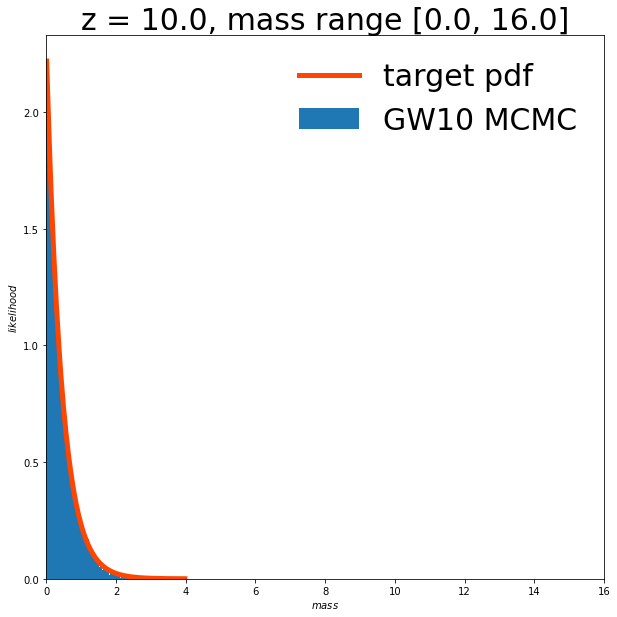

In [20]:
test_func, mass_chain = mass_sampling([0.0, 14.0], redshift = 10.0)
plot_pdf(mass_chain, "z = 10.0, mass range [0.0, 16.0]", func=test_func, xlims=[0.0, 16.0], ylog=False, bins='auto', label='GW10 MCMC', figsize = 10)